# Tech Challenge 3

## Dataset
    eCommerce behavior data from multi category store
    https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/data

## EDA - Exploratory Data Analysis

In [428]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [429]:
df = pd.read_csv(r"C:\WORK\FIAP-PosMLE\Tech Challenge 3\techchallenge03\datasets\2019-Oct-Test10K.csv")

### Data Understanding: Geral

In [430]:
df.shape

(9999, 9)

In [431]:
df.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8


In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     9999 non-null   object 
 1   event_type     9999 non-null   object 
 2   product_id     9999 non-null   int64  
 3   category_id    9999 non-null   int64  
 4   category_code  6722 non-null   object 
 5   brand          8557 non-null   object 
 6   price          9999 non-null   float64
 7   user_id        9999 non-null   int64  
 8   user_session   9999 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 703.2+ KB


In [433]:
df.describe()

,product_id,category_id,price,user_id
count,9.999000e+03,9.999000e+03,9999.000000,9.999000e+03
mean,1.023870e+07,2.055768e+18,294.098607,5.314159e+08
std,1.102406e+07,1.392063e+16,365.523534,1.691509e+07
min,1.002099e+06,2.053014e+18,0.000000,3.064418e+08
25%,1.005105e+06,2.053014e+18,62.940000,5.154591e+08
50%,5.100563e+06,2.053014e+18,159.330000,5.281100e+08
75%,1.620031e+07,2.053014e+18,362.940000,5.481027e+08
max,5.300000e+07,2.172371e+18,2574.070000,5.554648e+08


In [434]:
df.isnull().sum()

event_time          0
event_type          0
product_id          0
category_id         0
category_code    3277
brand            1442
price               0
user_id             0
user_session        0
dtype: int64

In [531]:
# Quantidade de clientes
num_users = df["user_id"].nunique()
print(num_users)

2867


## Data Understanding e Data Preparation: event_time
Possibilidades:
* Identificação de padrões de compras
* Identificação de Funil de conversão ao longo do tempo: view-cart-purchase

In [435]:
# Tratamento de event_time: separação por data, hora e dia
df['event_time'] = pd.to_datetime(df['event_time'], utc=True)
df['date'] = df['event_time'].dt.date
df['hour'] = df['event_time'].dt.hour
df['day'] = df['event_time'].dt.day
df['weekday'] = df['event_time'].dt.day_name()   # segunda, terça...
df['month'] = df['event_time'].dt.month
df['year'] = df['event_time'].dt.year

<Axes: title={'center': 'Eventos por Dia'}, xlabel='date'>

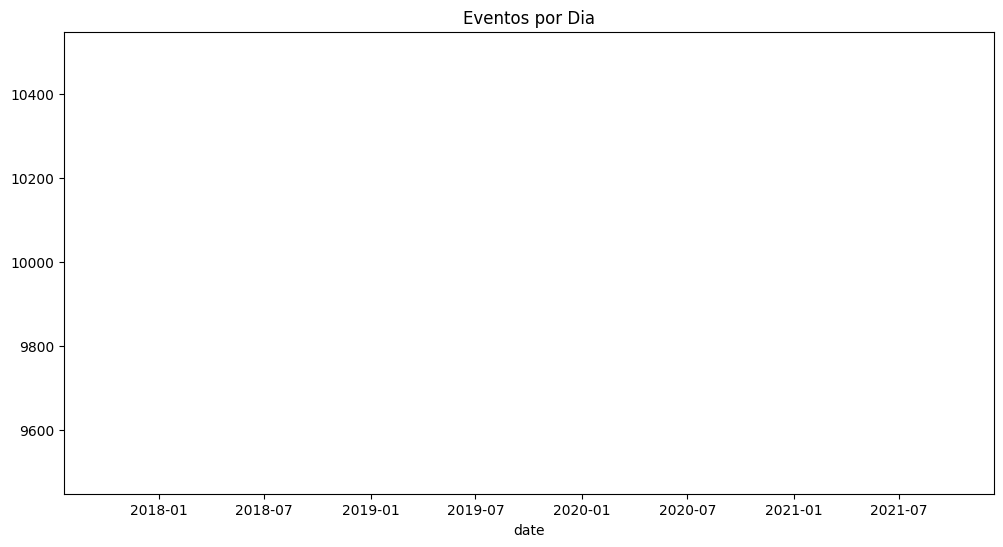

In [436]:
df.groupby('date')['event_type'].count().plot(kind='line', figsize=(12,6), title="Eventos por Dia")

<Axes: title={'center': 'Eventos por Hora do Dia'}, xlabel='hour'>

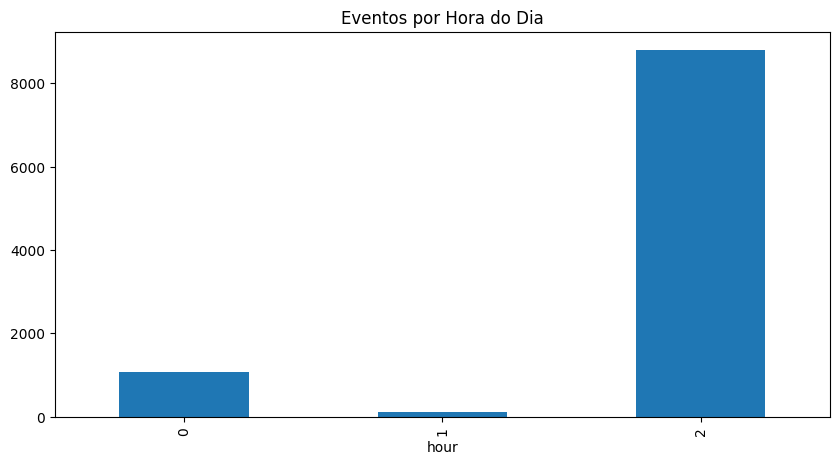

In [437]:
df['hour'].value_counts().sort_index().plot(kind='bar', figsize=(10,5), title="Eventos por Hora do Dia")


<Axes: title={'center': 'Eventos por Tipo ao Longo do Tempo'}, xlabel='date'>

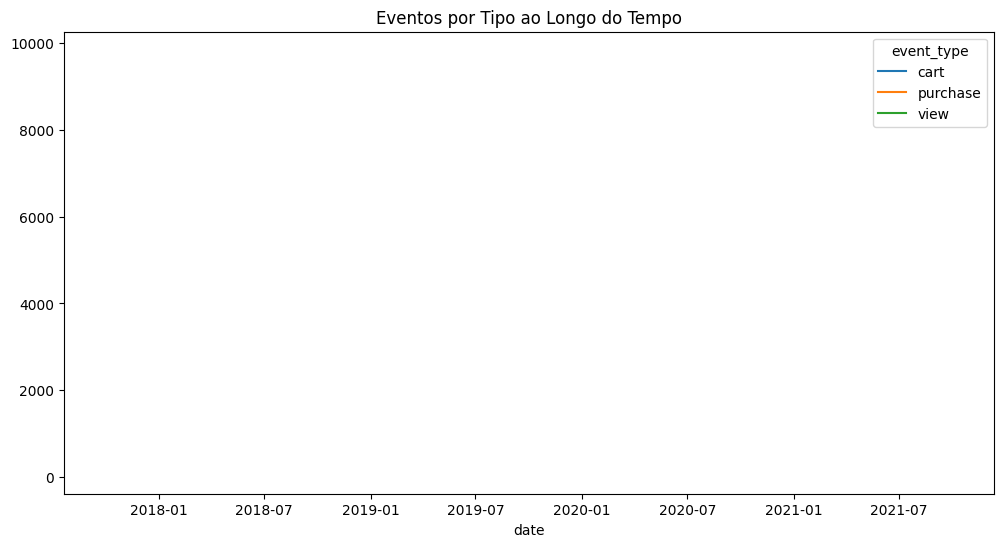

In [438]:
df.groupby(['date', 'event_type']).size().unstack().plot(figsize=(12,6), title="Eventos por Tipo ao Longo do Tempo")

<Axes: title={'center': 'Eventos por Dia da Semana'}, xlabel='weekday'>

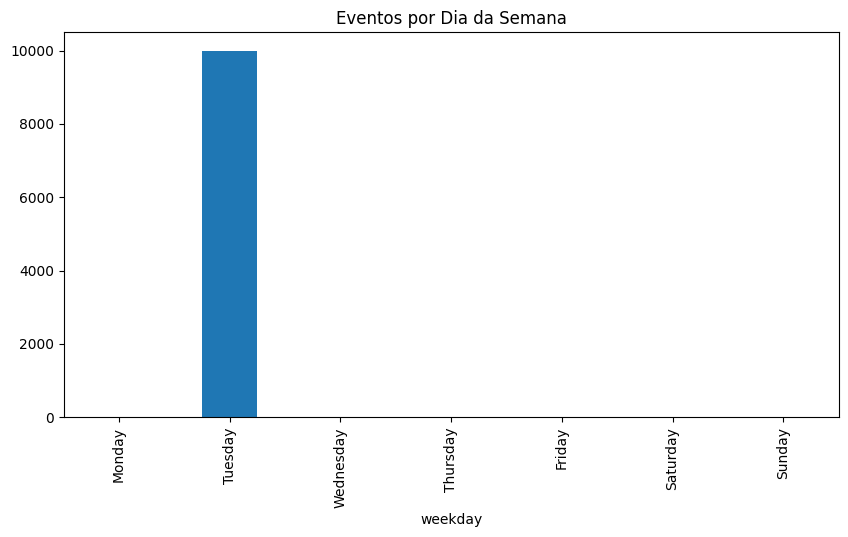

In [439]:
df['weekday'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).plot(kind='bar', figsize=(10,5), title="Eventos por Dia da Semana")


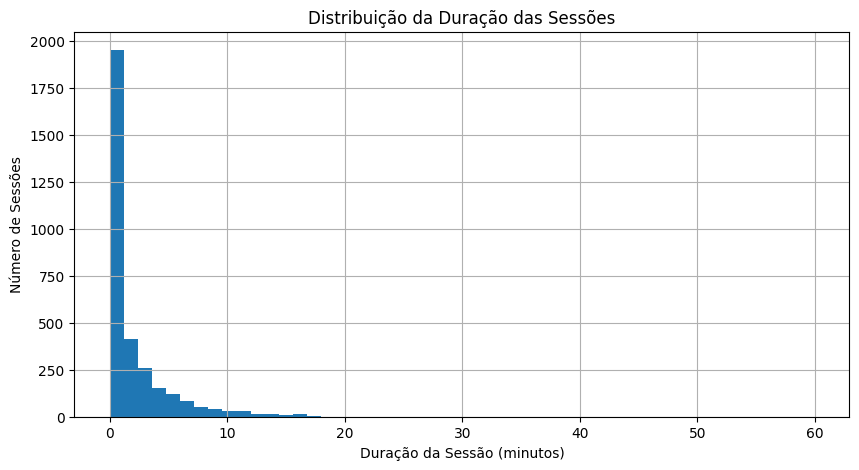

In [440]:
session_time = df.groupby('user_session')['event_time'].agg(['min','max'])
session_time['duration'] = (session_time['max'] - session_time['min']).dt.total_seconds() / 60
session_time['duration'].hist(bins=50, figsize=(10,5))
plt.xlabel("Duração da Sessão (minutos)")
plt.ylabel("Número de Sessões")
plt.title("Distribuição da Duração das Sessões")
plt.show()

In [441]:
session_time['duration'].describe()

count    3188.000000
mean        1.868272
std         3.165839
min         0.000000
25%         0.000000
50%         0.483333
75%         2.533333
max        59.933333
Name: duration, dtype: float64

In [442]:
q95 = session_time['duration'].quantile(0.95)  # limite no p95
filtered = session_time[session_time['duration'] <= q95]

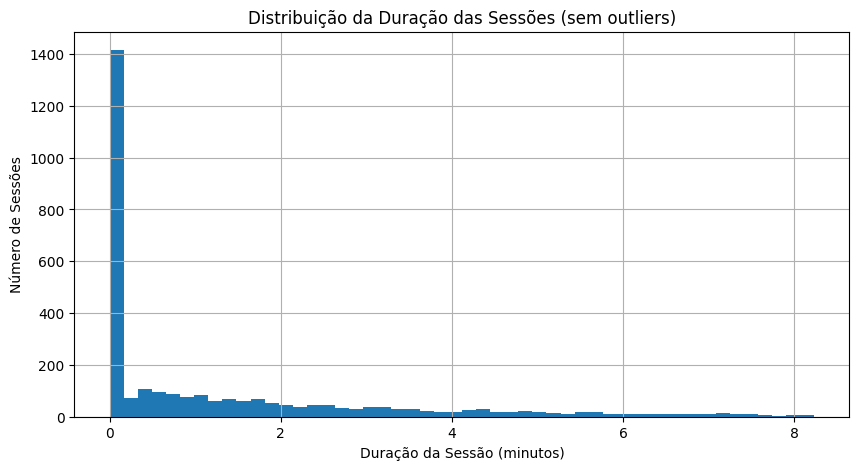

In [443]:
filtered['duration'].hist(bins=50, figsize=(10,5))
plt.xlabel("Duração da Sessão (minutos)")
plt.ylabel("Número de Sessões")
plt.title("Distribuição da Duração das Sessões (sem outliers)")
plt.show()

## Data Understanding e Data Preparation: event_type
Possibilidades:
* Identificação de padrões de compras
* Análise de Funil de conversão ao longo do tempo: view-cart-purchase
* Identificação de fraude: quantidade de 'cart' menor que 'purchase'

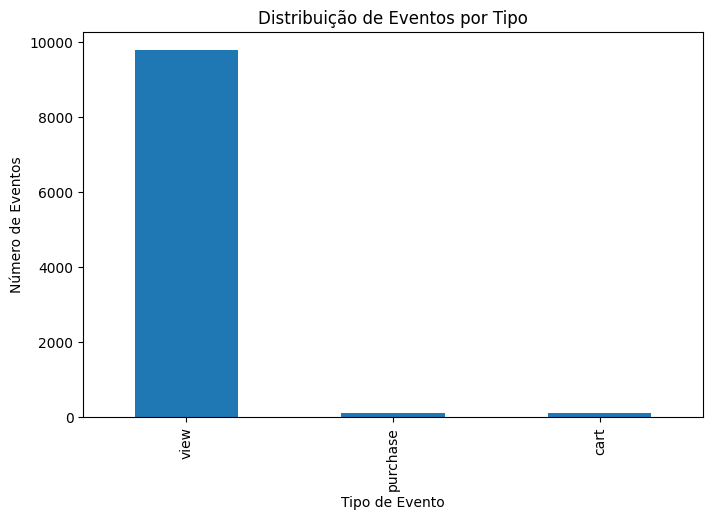

In [444]:
df['event_type'].value_counts().plot(kind='bar', figsize=(8,5))
plt.xlabel("Tipo de Evento")
plt.ylabel("Número de Eventos")
plt.title("Distribuição de Eventos por Tipo")
plt.show()

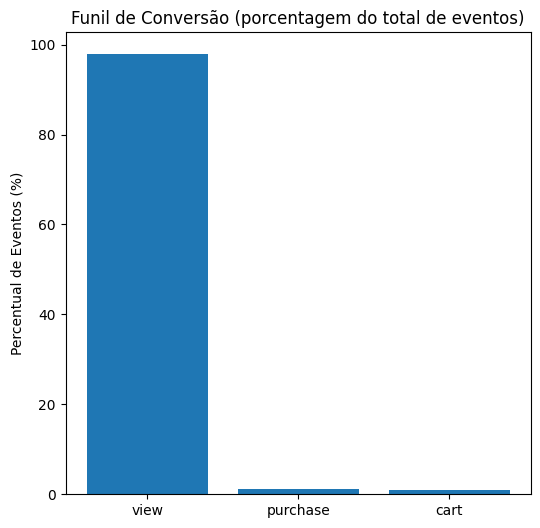

In [445]:
events = df['event_type'].value_counts()
conversion = events / events.sum() * 100

plt.figure(figsize=(6,6))
plt.bar(conversion.index, conversion.values)
plt.ylabel("Percentual de Eventos (%)")
plt.title("Funil de Conversão (porcentagem do total de eventos)")
plt.show()

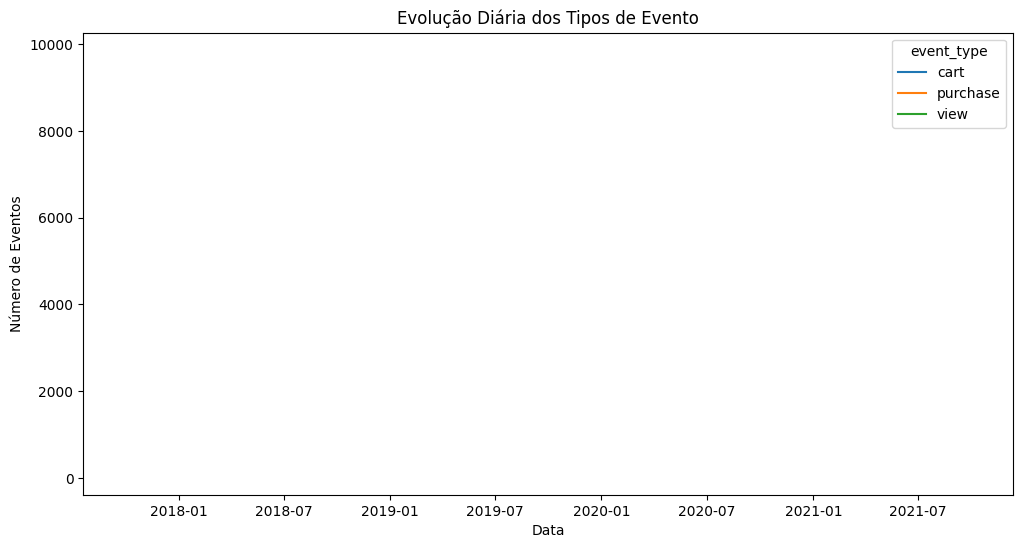

In [446]:
df['date'] = df['event_time'].dt.date
daily_events = df.groupby(['date', 'event_type']).size().unstack()

daily_events.plot(figsize=(12,6))
plt.xlabel("Data")
plt.ylabel("Número de Eventos")
plt.title("Evolução Diária dos Tipos de Evento")
plt.show()


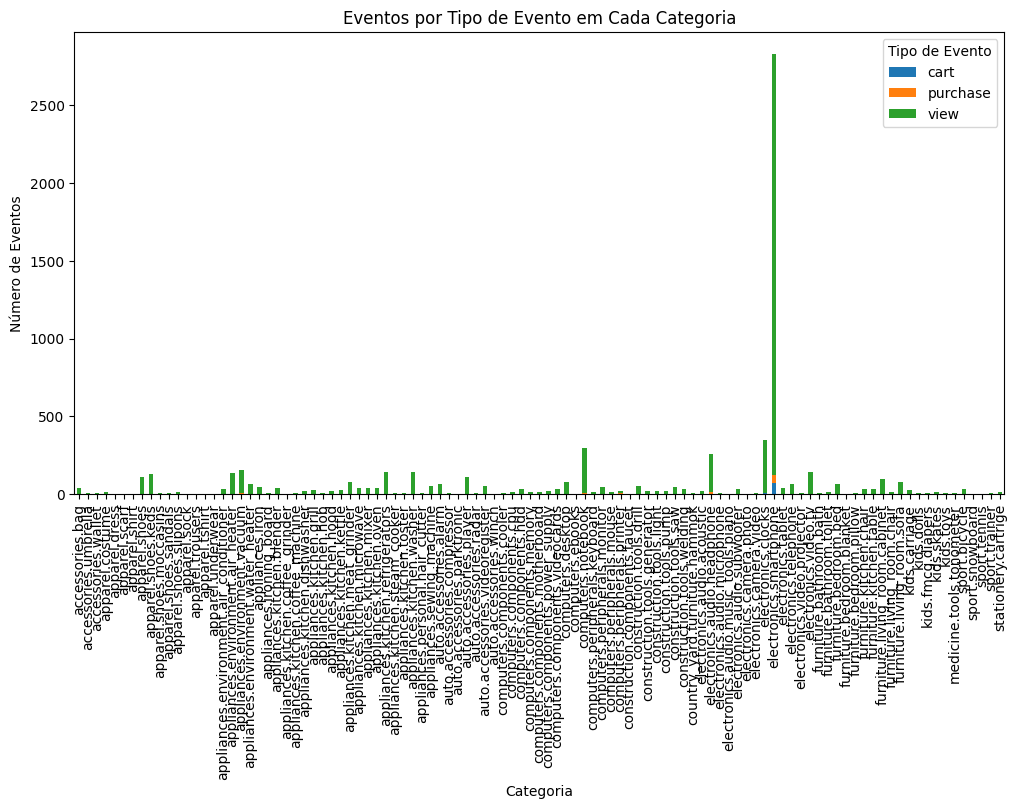

In [447]:
category_events = df.groupby(['category_code', 'event_type']).size().unstack().fillna(0)

category_events.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Categoria")
plt.ylabel("Número de Eventos")
plt.title("Eventos por Tipo de Evento em Cada Categoria")
plt.legend(title="Tipo de Evento")
plt.show()


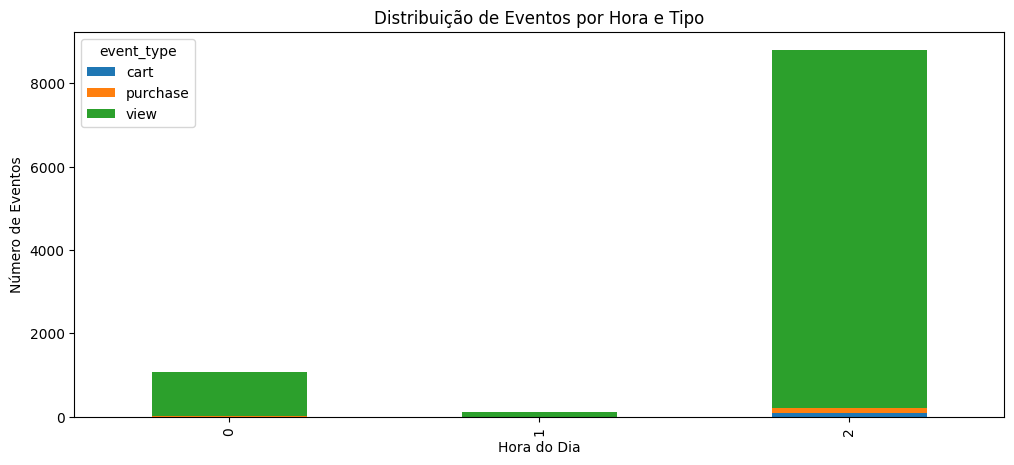

In [448]:
df['hour'] = df['event_time'].dt.hour
hourly_events = df.groupby(['hour', 'event_type']).size().unstack()

hourly_events.plot(kind='bar', stacked=True, figsize=(12,5))
plt.xlabel("Hora do Dia")
plt.ylabel("Número de Eventos")
plt.title("Distribuição de Eventos por Hora e Tipo")
plt.show()


In [449]:
list(df.event_type.unique())
print(df['event_type'].value_counts())

event_type
view        9784
purchase     118
cart          97
Name: count, dtype: int64


## Data Understanding e Data Preparation: category_id /category_code
Possibilidades:
* Identificação de quais categorias tem mais visualizações, adições ao carrinho de compras 
* Identificação de quais categorias perdem clientes no funil
* Identificação de Sazonalidade de vendas
* Recomendações de produtos

In [450]:
list(df.category_code.unique())
print(df['category_code'].value_counts())

category_code
electronics.smartphone               2830
electronics.clocks                    350
computers.notebook                    294
electronics.audio.headphone           259
appliances.environment.vacuum         153
                                     ... 
auto.accessories.winch                  1
appliances.kitchen.coffee_grinder       1
apparel.shirt                           1
sport.tennis                            1
apparel.scarf                           1
Name: count, Length: 103, dtype: int64


In [451]:
# Tratamento de category_code: para os valores ausentes (NaN) de 'category_code', usar os valores mais frequentes de 'brand'
df['category_code'] = df.groupby('brand')['category_code'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))

In [452]:
# Tratamento de category_code: preenche os valores de category_code à partir de inferência em category_id - preenche com base em IDs conhecidos
mapping = df.dropna().drop_duplicates(subset=['category_id', 'category_code'])
mapping_dict = dict(zip(mapping['category_id'], mapping['category_code']))

In [453]:
df['category_code'] = df.apply(
    lambda row: mapping_dict.get(row['category_id'], row['category_code']), axis=1)

In [454]:
# Tratamento de category_code: para o que restar de NaN, preencher com fillna
df['category_code'] = df['category_code'].fillna('unknown')

In [455]:
# separa categoria principal e subcategoria
df[['main_category','sub_category']] = df['category_code'].str.split('.', n=1, expand=True)

In [456]:
df['main_category'].value_counts()

main_category
electronics     3996
unknown         2250
appliances      1571
computers        623
furniture        604
apparel          284
auto             250
construction     204
accessories       66
kids              65
sport             42
medicine          29
stationery        11
country_yard       4
Name: count, dtype: int64

In [457]:
category_event_counts = df.groupby(['main_category', 'event_type']).size().unstack()
category_event_counts

event_type,cart,purchase,view
main_category,,,
accessories,NaN,1.0,65.0
apparel,NaN,1.0,283.0
appliances,5.0,11.0,1555.0
auto,NaN,1.0,249.0
computers,3.0,7.0,613.0
construction,NaN,2.0,202.0
country_yard,NaN,NaN,4.0
electronics,80.0,72.0,3844.0
furniture,NaN,2.0,602.0


In [458]:
category_event_counts['total_events'] = category_event_counts.sum(axis=1)
category_event_counts['view_to_cart_rate'] = category_event_counts['cart'] / category_event_counts['view'] * 100
category_event_counts['cart_to_purchase_rate'] = category_event_counts['purchase'] / category_event_counts['cart'] * 100

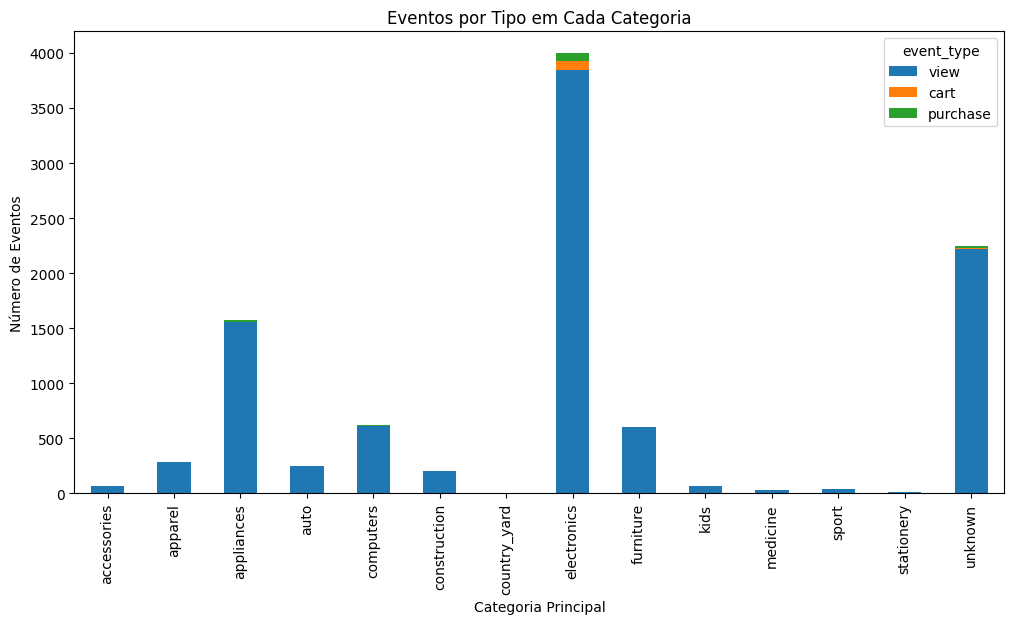

In [459]:
category_event_counts[['view','cart','purchase']].plot(
    kind='bar', stacked=True, figsize=(12,6)
)
plt.ylabel("Número de Eventos")
plt.xlabel("Categoria Principal")
plt.title("Eventos por Tipo em Cada Categoria")
plt.show()

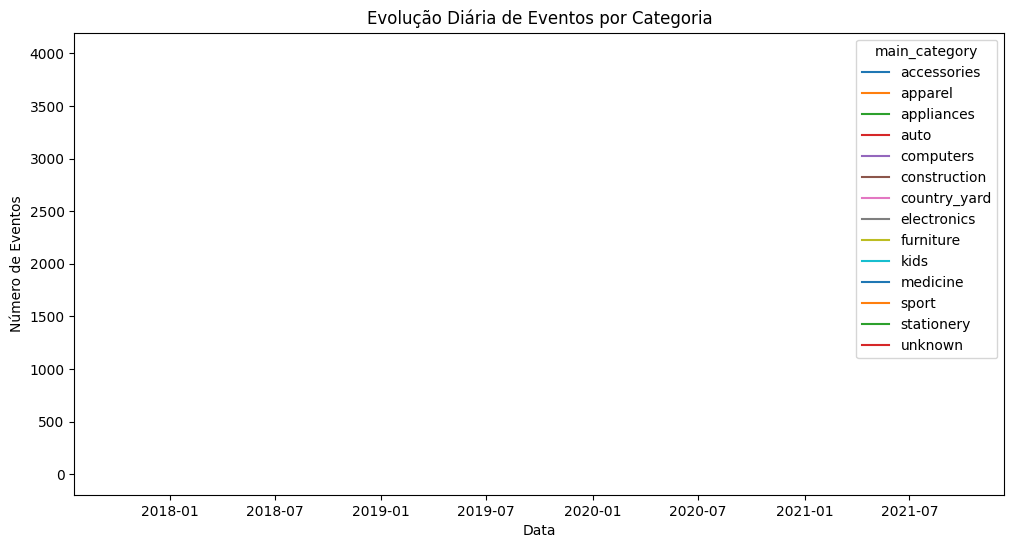

In [460]:
df['date'] = pd.to_datetime(df['event_time']).dt.date
daily_category_events = df.groupby(['date','main_category']).size().unstack().fillna(0)

daily_category_events.plot(figsize=(12,6))
plt.ylabel("Número de Eventos")
plt.xlabel("Data")
plt.title("Evolução Diária de Eventos por Categoria")
plt.show()

## Data Understanding e Data Preparation: brand
Possibilidades:
* Identificação de quais marcas tem mais visualizações, adições ao carrinho de compras 
* Identificação de quais marcas perdem clientes no funil
* Identificação de Sazonalidade de vendas
* Recomendações de marcas

In [461]:
list(df.brand.unique())
print(df['brand'].value_counts())

brand
samsung      1231
apple        1039
xiaomi        698
huawei        306
lucente       128
             ... 
ditreex         1
takeit          1
cellio          1
dremel          1
guerisson       1
Name: count, Length: 671, dtype: int64


In [462]:
# Tratamento de brand: para os valores ausentes (NaN) de 'brand',inferir à partir de 'product_id'
prod_map = df.dropna(subset=['brand']).drop_duplicates('product_id')
prod_map = dict(zip(prod_map['product_id'], prod_map['brand']))

df['brand'] = df.apply(
    lambda row: prod_map.get(row['product_id'], row['brand']), axis=1
)

In [463]:
# Tratamento de brand: para os valores ausentes (NaN) de 'brand', preencher com 'unknown'
df['brand'] = df['brand'].fillna('unknown')


In [464]:
df['brand'].value_counts(normalize=True) * 100

brand
unknown       14.421442
samsung       12.311231
apple         10.391039
xiaomi         6.980698
huawei         3.060306
                ...    
fit            0.010001
alcasta        0.010001
maestro        0.010001
altinbasak     0.010001
mitasu         0.010001
Name: proportion, Length: 672, dtype: float64

In [465]:
brand_counts = df.groupby(['brand','event_type']).size().unstack().fillna(0)
brand_counts['view_to_cart_rate'] = brand_counts['cart'] / brand_counts['view'] * 100
brand_counts['cart_to_purchase_rate'] = brand_counts['purchase'] / brand_counts['cart'] * 100
brand_counts

event_type,cart,purchase,view,view_to_cart_rate,cart_to_purchase_rate
brand,,,,,
a-case,0.0,0.0,3.0,0.0,NaN
a-elita,0.0,0.0,1.0,0.0,NaN
academie,0.0,0.0,1.0,0.0,NaN
acer,0.0,1.0,94.0,0.0,inf
acme,0.0,0.0,2.0,0.0,NaN
...,...,...,...,...,...
zemex,0.0,0.0,1.0,0.0,NaN
zeppelin,0.0,0.0,1.0,0.0,NaN
zerten,0.0,0.0,1.0,0.0,NaN


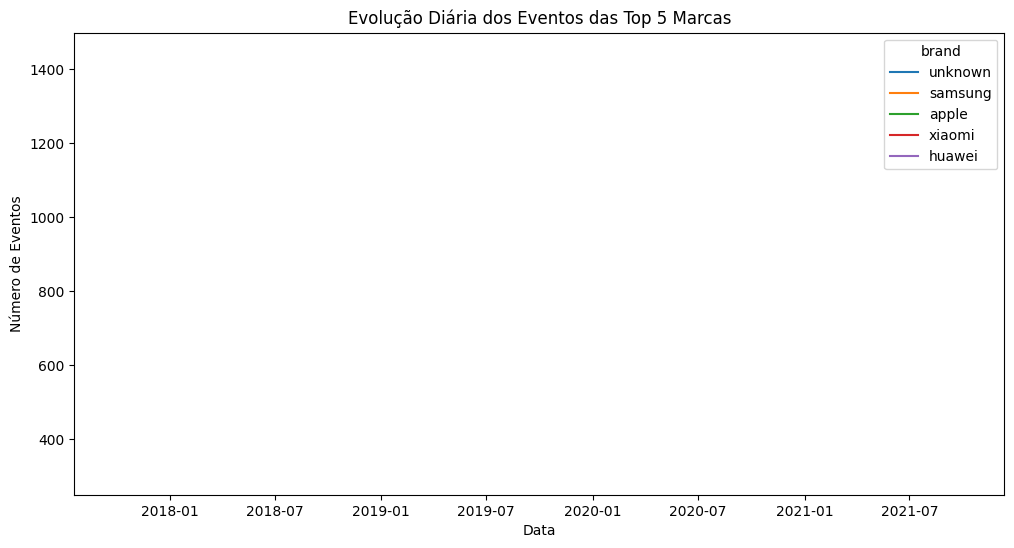

In [466]:
total_events_per_brand = df['brand'].value_counts()
top5_brands = total_events_per_brand.head(5).index.tolist()

daily_brand_events = df.groupby(['date','brand']).size().unstack().fillna(0)
daily_top5 = daily_brand_events[top5_brands]

daily_top5.plot(figsize=(12,6))
plt.xlabel("Data")
plt.ylabel("Número de Eventos")
plt.title("Evolução Diária dos Eventos das Top 5 Marcas")
plt.show()

## Data Understanding e Data Preparation: price
Possibilidades:
* Análise taxa de compras por faixa de preço
* Identificação de outliers e erros de cadastro para ajuste
* Segmentação de clientes por faixas de preços e ticket médio
* Comparação de preço médio por categoria ou marca para ajuste de preço (melhoria de vendas ou margem de lucro)

In [467]:
df['price'].describe()

count    9999.000000
mean      294.098607
std       365.523534
min         0.000000
25%        62.940000
50%       159.330000
75%       362.940000
max      2574.070000
Name: price, dtype: float64

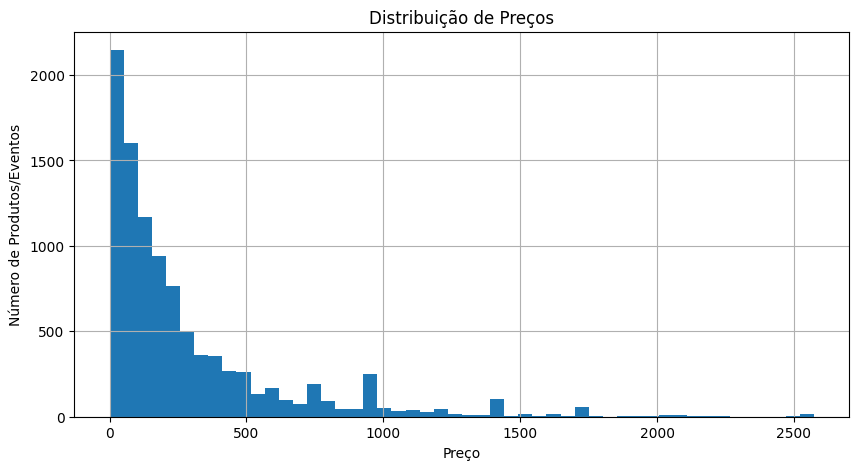

In [468]:
df['price'].hist(bins=50, figsize=(10,5))
plt.xlabel("Preço")
plt.ylabel("Número de Produtos/Eventos")
plt.title("Distribuição de Preços")
plt.show()

In [469]:
df.groupby('main_category')['price'].mean().sort_values(ascending=False)
df.groupby('brand')['price'].mean().sort_values(ascending=False)

brand
scott       2391.310
rado        2290.920
peda        2100.850
longines    1589.058
mercury     1586.140
              ...   
tamish         3.600
wess           3.340
wuw            3.090
domenik        2.860
briverre       2.470
Name: price, Length: 672, dtype: float64

C:\Users\Walmir\AppData\Local\Temp\ipykernel_21264\448944997.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion = df.groupby(pd.cut(df['price'], bins=10))['event_type'].value_counts(normalize=True).unstack()


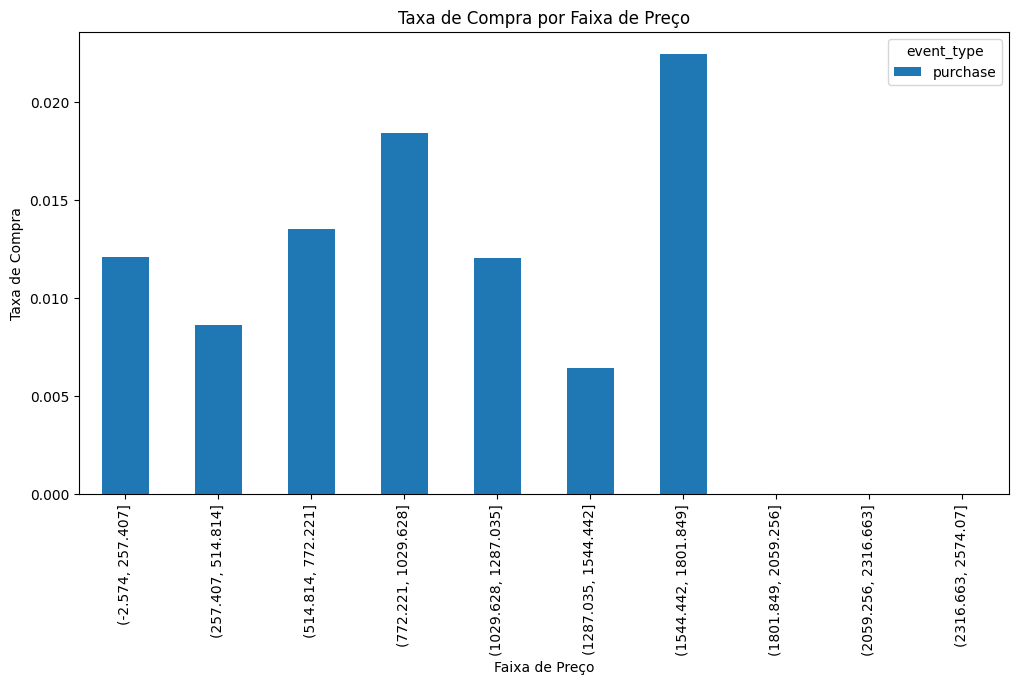

In [470]:
conversion = df.groupby(pd.cut(df['price'], bins=10))['event_type'].value_counts(normalize=True).unstack()
conversion[['purchase']].plot(kind='bar', figsize=(12,6))
plt.xlabel("Faixa de Preço")
plt.ylabel("Taxa de Compra")
plt.title("Taxa de Compra por Faixa de Preço")
plt.show()

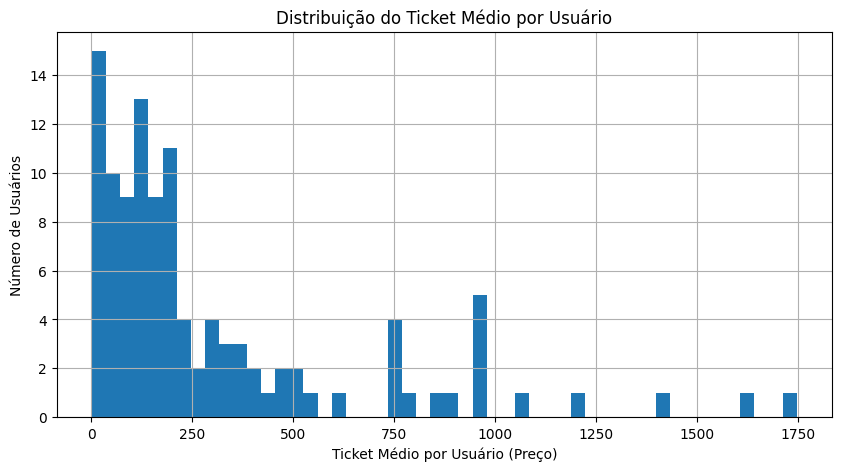

In [471]:
df[df['event_type']=='purchase'].groupby('user_id')['price'].mean().hist(bins=50, figsize=(10,5))
plt.xlabel("Ticket Médio por Usuário (Preço)")
plt.ylabel("Número de Usuários")
plt.title("Distribuição do Ticket Médio por Usuário")
plt.show()


In [472]:
df['price'].quantile([0.01,0.99])  # limites 1% e 99%

0.01       5.1298
0.99    1747.7900
Name: price, dtype: float64

## Data Understanding e Data Preparation: user_id e user_session
Possibilidades:
* Análise de picos de tráfego com maior conversão
* Previsão de demanda futura (gerenciamento de estoque)
* Detecção de anomalias de tráfego (bots e problemas técnicos)
* Detecção de onde os usuários abandonam o funil de vendas

In [473]:
list(df.user_session.unique())
print(df['user_session'].value_counts())

user_session
aa01487d-d46a-4704-9f1c-29613fbdaf1e    43
862d6815-ceac-4b6c-9baa-e99dfff0f40c    28
2885756b-57f6-487b-946d-8cac7ddc4b66    27
f7db7dad-ebfc-4f66-8ed4-45dfe8717261    25
05664614-7845-4809-ac08-970a912858d0    24
                                        ..
40cb886c-73ca-48d1-bcf4-41bbba3c2af1     1
1a23924d-1bd3-4e0b-9687-4ce0932a1705     1
e3151795-c355-4efa-acf6-e1fe1bebeee5     1
50a293fb-5940-41b2-baf3-17af0e812101     1
b5bdd0b3-4ca2-4c55-939e-9ce44bb50abd     1
Name: count, Length: 3188, dtype: int64


In [474]:
# Agrupar por user_session e contar quantos user_id distintos existem
inconsistencias = (
    df.groupby("user_session")["user_id"]
      .nunique()
      .reset_index()
      .query("user_id > 1")   # pega apenas sessões com mais de 1 user_id
)
print(inconsistencias)

                             user_session  user_id
473  2759bd71-1333-4348-816d-c02912f6ebd4        2


In [475]:
# Visualizar os registros originais que são inconsistentes
registros_inconsistentes = df[df["user_session"].isin(inconsistencias["user_session"])]
print(registros_inconsistentes)

                    event_time event_type  product_id          category_id  \
4750 2019-10-01 02:27:45+00:00       view    10300637  2053013553115300101   
5094 2019-10-01 02:28:27+00:00       view    10301026  2053013553115300101   

     category_code      brand  price    user_id  \
4750       unknown  silverlit  14.39  555463297   
5094       unknown  silverlit  11.56  555463292   

                              user_session        date  hour  day  weekday  \
4750  2759bd71-1333-4348-816d-c02912f6ebd4  2019-10-01     2    1  Tuesday   
5094  2759bd71-1333-4348-816d-c02912f6ebd4  2019-10-01     2    1  Tuesday   

      month  year main_category sub_category  
4750     10  2019       unknown         None  
5094     10  2019       unknown         None  


<Axes: >

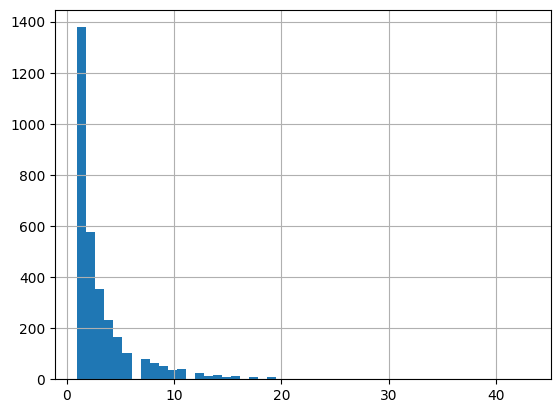

In [476]:
events_per_session = df.groupby('user_session').size()
events_per_session.hist(bins=50)


<Axes: >

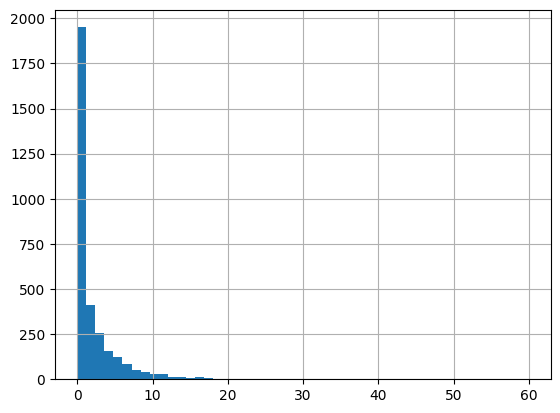

In [477]:
session_time = df.groupby('user_session')['event_time'].agg(['min','max'])
session_time['duration_minutes'] = (session_time['max'] - session_time['min']).dt.total_seconds() / 60
session_time['duration_minutes'].hist(bins=50)

In [478]:
session_events = df.groupby(['user_session','event_type']).size().unstack().fillna(0)
session_events


event_type,cart,purchase,view
user_session,,,
00334c2e-e8e5-463f-ae4e-f44f9796ccf4,0.0,0.0,2.0
006d2e99-7346-4240-b445-2d9cc21ffdfe,0.0,0.0,3.0
008d7f4b-ed7a-484b-88bd-b0aacd787fb7,0.0,0.0,1.0
009074dd-dda3-4032-9e3e-b45fed5fa579,0.0,0.0,1.0
0090a953-4885-db5f-97aa-8a89b7adbbfb,0.0,0.0,1.0
...,...,...,...
ffc72f0a-6428-5bdd-9032-90c2067bc115,0.0,0.0,1.0
ffecf7c3-5348-49cd-aa68-419a8654367e,0.0,0.0,3.0
ffeda3e8-e3d1-4345-b585-3dc601692fa2,0.0,0.0,2.0


<Axes: >

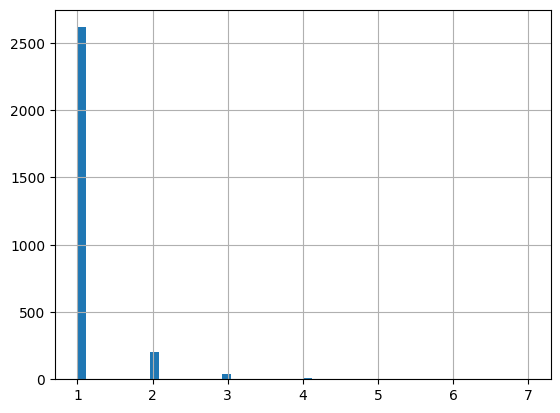

In [479]:
sessions_per_user = df.groupby('user_id')['user_session'].nunique()
sessions_per_user.hist(bins=50)

In [480]:
# Tempo médio entre sessões
df_sorted = df.sort_values(['user_id','event_time'])
df_sorted['prev_session'] = df_sorted.groupby('user_id')['event_time'].shift(1)
df_sorted['time_since_last'] = (df_sorted['event_time'] - df_sorted['prev_session']).dt.total_seconds() / 3600
df_sorted

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date,hour,day,weekday,month,year,main_category,sub_category,prev_session,time_since_last
1150,2019-10-01 01:32:09+00:00,view,2501614,2053013564003713919,appliances.kitchen.oven,redmond,164.71,306441847,47641f8a-3aba-471a-8d07-014deccec567,2019-10-01,1,1,Tuesday,10,2019,appliances,kitchen.oven,NaT,NaN
2774,2019-10-01 02:23:02+00:00,view,7202317,2053013553165631753,unknown,lego,24.45,400972610,a6b41834-75dd-4cd5-ace6-cbe1a4fe54df,2019-10-01,2,1,Tuesday,10,2019,unknown,None,NaT,NaN
2936,2019-10-01 02:23:27+00:00,view,7203226,2053013553165631753,unknown,lego,44.45,400972610,a6b41834-75dd-4cd5-ace6-cbe1a4fe54df,2019-10-01,2,1,Tuesday,10,2019,unknown,None,2019-10-01 02:23:02+00:00,0.006944
3063,2019-10-01 02:23:49+00:00,view,7203227,2053013553165631753,unknown,lego,24.45,400972610,a6b41834-75dd-4cd5-ace6-cbe1a4fe54df,2019-10-01,2,1,Tuesday,10,2019,unknown,None,2019-10-01 02:23:27+00:00,0.006111
3106,2019-10-01 02:23:56+00:00,view,7203226,2053013553165631753,unknown,lego,44.45,400972610,a6b41834-75dd-4cd5-ace6-cbe1a4fe54df,2019-10-01,2,1,Tuesday,10,2019,unknown,None,2019-10-01 02:23:49+00:00,0.001944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9830,2019-10-01 02:37:01+00:00,view,5100719,2053013553341792533,electronics.clocks,samsung,151.61,555464717,bf379d52-5fd8-4d22-b359-0118411cb8f1,2019-10-01,2,1,Tuesday,10,2019,electronics,clocks,2019-10-01 02:36:52+00:00,0.002500
9791,2019-10-01 02:36:56+00:00,view,1003310,2053013555631882655,electronics.smartphone,apple,747.23,555464729,504001a6-7129-4efc-bfdc-4edec6902f82,2019-10-01,2,1,Tuesday,10,2019,electronics,smartphone,NaT,NaN
9905,2019-10-01 02:37:09+00:00,view,1004903,2053013555631882655,electronics.smartphone,huawei,111.82,555464753,0d2490c6-bbe6-4917-be22-32a93d300728,2019-10-01,2,1,Tuesday,10,2019,electronics,smartphone,NaT,NaN
9949,2019-10-01 02:37:14+00:00,view,15800006,2053013560144954031,unknown,karcher,102.94,555464780,757e35bf-0ce9-4d7c-8ba9-a87ff65808ad,2019-10-01,2,1,Tuesday,10,2019,unknown,None,NaT,NaN


In [481]:
# Conversão por sessão
purchased_sessions = df[df['event_type']=='purchase']['user_session'].nunique()
total_sessions = df['user_session'].nunique()
conversion_rate = purchased_sessions / total_sessions * 100
conversion_rate


3.4818067754077795

In [482]:
df.groupby(['user_session','main_category']).size().unstack().fillna(0)

main_category,accessories,apparel,appliances,auto,computers,construction,country_yard,electronics,furniture,kids,medicine,sport,stationery,unknown
user_session,,,,,,,,,,,,,,
00334c2e-e8e5-463f-ae4e-f44f9796ccf4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
006d2e99-7346-4240-b445-2d9cc21ffdfe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
008d7f4b-ed7a-484b-88bd-b0aacd787fb7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
009074dd-dda3-4032-9e3e-b45fed5fa579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0090a953-4885-db5f-97aa-8a89b7adbbfb,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc72f0a-6428-5bdd-9032-90c2067bc115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ffecf7c3-5348-49cd-aa68-419a8654367e,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffeda3e8-e3d1-4345-b585-3dc601692fa2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


## Mapa de Calor

In [483]:
heatmap_data = pd.crosstab(df['main_category'], df['event_type'])

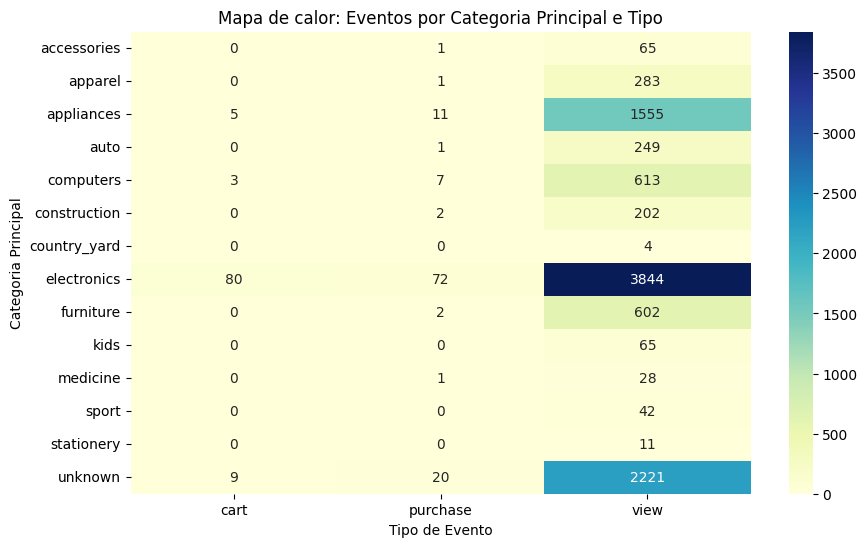

In [484]:
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Mapa de calor: Eventos por Categoria Principal e Tipo")
plt.ylabel("Categoria Principal")
plt.xlabel("Tipo de Evento")
plt.show()

In [485]:
numeric_cols = df[['price','category_id']] # user_id ficou de fora
corr = numeric_cols.corr()

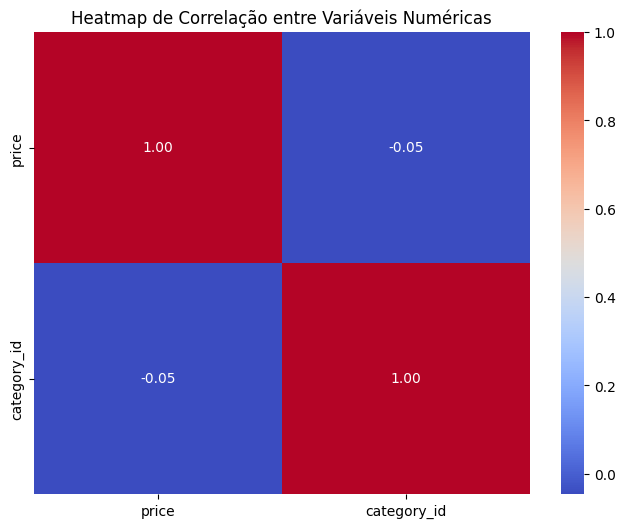

In [486]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de Correlação entre Variáveis Numéricas")
plt.show()

In [487]:
price_by_category = df.groupby('main_category')['price'].mean().sort_values(ascending=False)

In [488]:
# Filtrar apenas eventos de compra
purchase_df = df[df['event_type'] == 'purchase']

# Contar compras por categoria principal
top5_categories = purchase_df['main_category'].value_counts().head(5).index.tolist()
print(top5_categories)

['electronics', 'unknown', 'appliances', 'computers', 'construction']


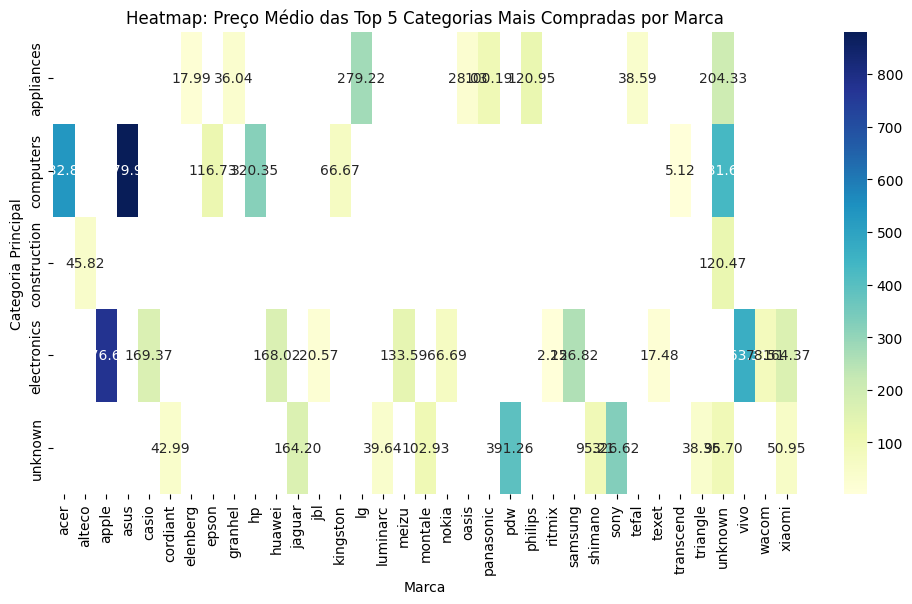

In [489]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = purchase_df[purchase_df['main_category'].isin(top5_categories)]

# Heatmap Data - Pivot table: main_category x brand → número de compras
heatmap_data2 = heatmap_data.pivot_table(
    index='main_category', 
    columns='brand', 
    values='price',  # para preço médio, ou 'user_id' para contar compras
    aggfunc='mean'   # 'count' se quiser contagem de compras
)
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap: Preço Médio das Top 5 Categorias Mais Compradas por Marca")
plt.xlabel("Marca")
plt.ylabel("Categoria Principal")
plt.show()

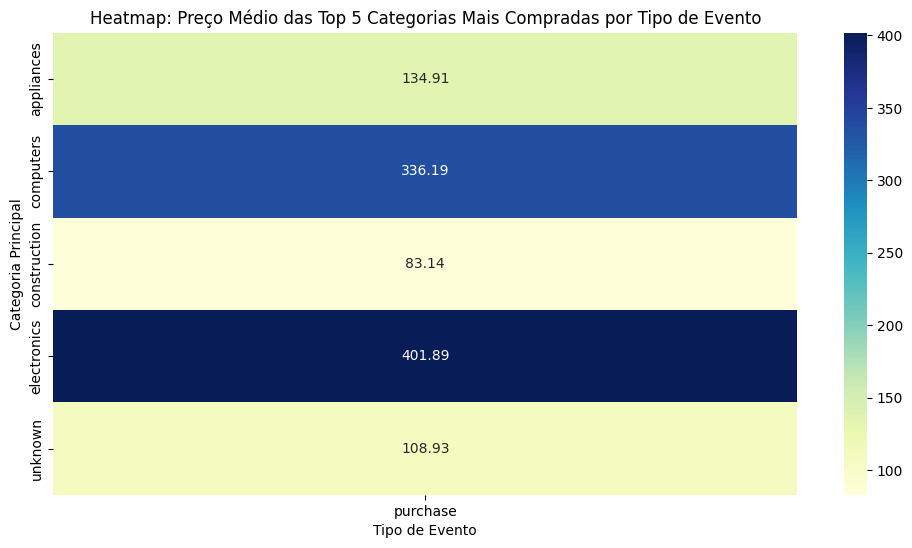

In [490]:
# Heatmap Data - Pivot table: main_category x event_type → número de compras
heatmap_data3 = heatmap_data.pivot_table(
    index='main_category', 
    columns='event_type', 
    values='price',  # para preço médio, ou 'user_id' para contar compras
    aggfunc='mean'   # 'count' se quiser contagem de compras
)
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data3, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap: Preço Médio das Top 5 Categorias Mais Compradas por Tipo de Evento")
plt.xlabel("Tipo de Evento")
plt.ylabel("Categoria Principal")
plt.show()

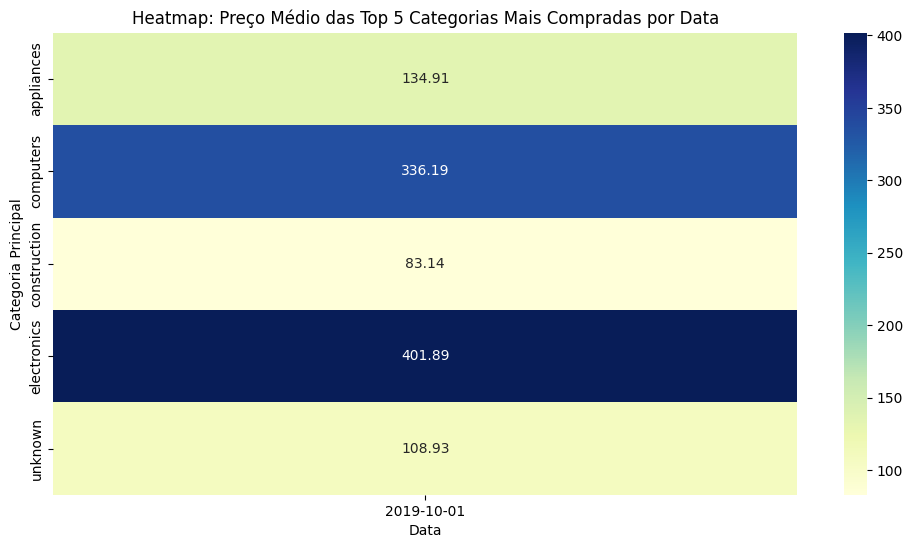

In [491]:
# Heatmap Data - Pivot table: main_category x date → número de compras
heatmap_data4 = heatmap_data.pivot_table(
    index='main_category', 
    columns='date', 
    values='price',  # para preço médio, ou 'user_id' para contar compras
    aggfunc='mean'   # 'count' se quiser contagem de compras
)
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data4, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap: Preço Médio das Top 5 Categorias Mais Compradas por Data")
plt.xlabel("Data")
plt.ylabel("Categoria Principal")
plt.show()

## Tarefas para Machine Learning sugeridos
* Classificação - Target categórica: previsão se uma sessão vai resultar em compra; previsão de churn ou abandono; preços fora do padrão;
* Regressão - Target numérica: previsão de preço de produto, com base na concorrência (marca); ticket médio por perfil de usuário; previsão de vendas diárias; tráfego por sessão; 
* Agrupamento: grupos de clientes mais rentáveis; grupos de produtos para planejamento de oferta;

### Vou trabalhar em:

* Modelo 1 - Classificação - Preços fora do Padrão
* Modelo 2 - Agrupamento - Grupos de Clientes mais Rentáveis


## Modelo 1 - Classificação - Preços fora do Padrão
### Classes: outlier=1 (preço fora do padrão); outlier=0 (preço normal)

In [492]:
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date,hour,day,weekday,month,year,main_category,sub_category
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,unknown,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,2019-10-01,0,1,Tuesday,10,2019,unknown,None
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01,0,1,Tuesday,10,2019,appliances,environment.water_heater
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,unknown,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,2019-10-01,0,1,Tuesday,10,2019,furniture,living_room.sofa
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01,0,1,Tuesday,10,2019,computers,notebook
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01,0,1,Tuesday,10,2019,electronics,smartphone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2019-10-01 02:37:18+00:00,view,6200966,2053013552293216471,appliances.environment.air_heater,saturn,27.03,513265169,caa06974-210d-4147-82a4-1c5646b5d3a6,2019-10-01,2,1,Tuesday,10,2019,appliances,environment.air_heater
9995,2019-10-01 02:37:18+00:00,view,45600168,2113934850560885372,apparel.shoes.keds,nike,59.18,539620652,2b8f3a28-5ca3-4038-a48f-021db1c8d1dc,2019-10-01,2,1,Tuesday,10,2019,apparel,shoes.keds
9996,2019-10-01 02:37:18+00:00,view,32403314,2053013566562238479,construction.tools.light,unknown,25.48,516770039,76b06dcb-c92f-4fa8-8d35-d290cadc29c5,2019-10-01,2,1,Tuesday,10,2019,construction,tools.light
9997,2019-10-01 02:37:18+00:00,view,1004838,2053013555631882655,electronics.smartphone,oppo,179.38,527209005,cbfdc1b0-39b7-4d1d-bce3-b79fc6b6c7cf,2019-10-01,2,1,Tuesday,10,2019,electronics,smartphone


In [493]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [494]:
def outlier_iqr(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    return ~group.between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

In [495]:
df['outlier'] = df.groupby('category_id')['price'].transform(outlier_iqr).astype(int)

In [496]:
df['price_ratio_cat'] = df.groupby('category_id')['price'].transform(lambda x: x / x.mean())
df = df[df["price_ratio_cat"].notnull()]
#df.isnull().sum()

In [497]:
X = df[['price', 'price_ratio_cat']]
y = df['outlier']

# Split e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [498]:
print(X.shape)
print(y.shape)

(9997, 2)
(9997,)


In [499]:
print(X.shape)
print(y.shape)

(9997, 2)
(9997,)


In [500]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Avaliação Conj. Testes (X_test)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2839
           1       0.82      0.48      0.60       161

    accuracy                           0.97      3000
   macro avg       0.90      0.74      0.79      3000
weighted avg       0.96      0.97      0.96      3000



In [501]:
# Avaliação Conj. Treinamento (X_train)
y_pred2 = model.predict(X_train)
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6595
           1       0.89      0.55      0.68       402

    accuracy                           0.97      6997
   macro avg       0.93      0.77      0.83      6997
weighted avg       0.97      0.97      0.97      6997



In [502]:
import numpy as np
y_combined = list(zip(y_pred, y_pred2))
print(y_pred.shape)
print(y_pred2.shape)
print(X.shape)
y_combined = np.concatenate([y_pred, y_pred2])
print(y_combined.shape)



(3000,)
(6997,)
(9997, 2)
(9997,)


In [503]:
X['oulier previsto'] = y_combined
X

C:\Users\Walmir\AppData\Local\Temp\ipykernel_21264\1648757875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['oulier previsto'] = y_combined


,price,price_ratio_cat,oulier previsto
0,35.79,1.000000,0
1,33.20,0.251767,0
2,543.10,1.019559,0
3,251.74,0.356822,0
4,1081.98,2.176353,0
...,...,...,...
9994,27.03,0.632914,0
9995,59.18,0.932458,1
9996,25.48,3.165217,0
9997,179.38,0.360815,0


## Modelo 2 - Agrupamento - Grupos de Clientes mais Rentáveis
### Com base no Comportamento do Cliente:
* Segmentação de Clientes mais Rentáveis - abordagem RFM; Recency (tempo desde última compra), Frequency (número de compras) e Monetary (total gasto)
* Custo de Serviço - muitos cart (carrinhos) abandonados (muitos carts e poucos purchase, baixa conversão) ou muitos view sem compra

In [504]:
import pandas as pd
from sklearn.cluster import KMeans
from datetime import datetime

# Carregar dados
# df.head()
df.isnull().sum()


event_time            0
event_type            0
product_id            0
category_id           0
category_code         0
brand                 0
price                 0
user_id               0
user_session          0
date                  0
hour                  0
day                   0
weekday               0
month                 0
year                  0
main_category         0
sub_category       2248
outlier               0
price_ratio_cat       0
dtype: int64

In [505]:
# Preenchimento de sub_category com ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Separar dados com sub_category preenchido
df_train = df[df["sub_category"].notnull()]
df_test = df[df["sub_category"].isnull()]

X_train = pd.get_dummies(df_train[["category_id","brand","price"]])
y_train = df_train["sub_category"]

X_test = pd.get_dummies(df_test[["category_id","brand","price"]])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)  # alinhar colunas

# Treinar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Preencher os valores faltantes
df.loc[df["sub_category"].isnull(), "sub_category"] = model.predict(X_test)

In [506]:
df.isnull().sum()

event_time         0
event_type         0
product_id         0
category_id        0
category_code      0
brand              0
price              0
user_id            0
user_session       0
date               0
hour               0
day                0
weekday            0
month              0
year               0
main_category      0
sub_category       0
outlier            0
price_ratio_cat    0
dtype: int64

In [507]:
# Filtrar apenas compras
purchases = df[df["event_type"] == "purchase"]

In [518]:
# Agregar por cliente
agg = purchases.groupby("user_id").agg(
    total_spent=("price", "sum"),
    frequency=("product_id", "count"),
    last_purchase=("event_time", "max")
).reset_index()

# Recency (em dias)
agg["last_purchase"] = pd.to_datetime(agg["last_purchase"])
max_date = pd.to_datetime(df["event_time"]).max()
agg["recency_days"] = (max_date - agg["last_purchase"]).dt.days
# Substituir NaN por 1000 (para indicar que não é recente para os product_id e event_time não encontrados)
agg["recency_days"] = agg["recency_days"].fillna(1000)
X.isnull().sum()


total_spent     0
frequency       0
recency_days    0
dtype: int64

In [521]:
# Normalizar features
X = agg[["total_spent", "frequency", "recency_days"]]
X.isnull().sum()


total_spent     0
frequency       0
recency_days    0
dtype: int64

In [523]:
X_scaled = (X - X.mean()) / X.std()
X_scaled["recency_days"] = X_scaled["recency_days"].fillna(1000)
X_scaled.isnull().sum()


total_spent     0
frequency       0
recency_days    0
dtype: int64

In [524]:
# Clusterização
kmeans = KMeans(n_clusters=4, random_state=42)
agg['cluster'] = kmeans.fit_predict(X_scaled)

# Identificar cluster mais lucrativo
cluster_summary = agg.groupby("cluster").agg(
    avg_spent=("total_spent","mean"),
    total_spent=("total_spent","sum"),
    customers=("user_id","count")
)
print(cluster_summary.sort_values("total_spent", ascending=False))

           avg_spent  total_spent  customers
cluster                                     
1        1001.027059     17017.46         17
0         167.486071     14068.83         84
2         388.541429      2719.79          7
3        1951.140000      1951.14          1


In [ ]:
df = df.merge(agg[["user_id", "cluster"]], on="user_id", how="left") # Alguns user_id não estão atribuidos à nenhum cluster por não terem registro de venda

In [528]:
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date,hour,day,weekday,month,year,main_category,sub_category,outlier,price_ratio_cat,cluster
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,unknown,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,2019-10-01,0,1,Tuesday,10,2019,unknown,iron,0,1.000000,NaN
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01,0,1,Tuesday,10,2019,appliances,environment.water_heater,0,0.251767,NaN
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,unknown,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,2019-10-01,0,1,Tuesday,10,2019,furniture,living_room.sofa,0,1.019559,NaN
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01,0,1,Tuesday,10,2019,computers,notebook,0,0.356822,NaN
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01,0,1,Tuesday,10,2019,electronics,smartphone,0,2.176353,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,2019-10-01 02:37:18+00:00,view,6200966,2053013552293216471,appliances.environment.air_heater,saturn,27.03,513265169,caa06974-210d-4147-82a4-1c5646b5d3a6,2019-10-01,2,1,Tuesday,10,2019,appliances,environment.air_heater,0,0.632914,NaN
9993,2019-10-01 02:37:18+00:00,view,45600168,2113934850560885372,apparel.shoes.keds,nike,59.18,539620652,2b8f3a28-5ca3-4038-a48f-021db1c8d1dc,2019-10-01,2,1,Tuesday,10,2019,apparel,shoes.keds,0,0.932458,NaN
9994,2019-10-01 02:37:18+00:00,view,32403314,2053013566562238479,construction.tools.light,unknown,25.48,516770039,76b06dcb-c92f-4fa8-8d35-d290cadc29c5,2019-10-01,2,1,Tuesday,10,2019,construction,tools.light,1,3.165217,NaN
9995,2019-10-01 02:37:18+00:00,view,1004838,2053013555631882655,electronics.smartphone,oppo,179.38,527209005,cbfdc1b0-39b7-4d1d-bce3-b79fc6b6c7cf,2019-10-01,2,1,Tuesday,10,2019,electronics,smartphone,0,0.360815,NaN


In [530]:
df_valid = df[df["cluster"].notnull()]
df_valid

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date,hour,day,weekday,month,year,main_category,sub_category,outlier,price_ratio_cat,cluster
51,2019-10-01 00:00:41+00:00,view,1003141,2053013555631882655,electronics.smartphone,apple,382.97,551377651,ca11a570-47da-4630-898b-9a03127703da,2019-10-01,0,1,Tuesday,10,2019,electronics,smartphone,0,0.770326,2.0
127,2019-10-01 00:01:45+00:00,view,1003305,2053013555631882655,electronics.smartphone,apple,612.43,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,2019-10-01,0,1,Tuesday,10,2019,electronics,smartphone,0,1.231875,2.0
129,2019-10-01 00:01:46+00:00,view,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,2019-10-01,0,1,Tuesday,10,2019,electronics,smartphone,0,0.263018,0.0
152,2019-10-01 00:02:08+00:00,view,1002528,2053013555631882655,electronics.smartphone,apple,643.23,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,2019-10-01,0,1,Tuesday,10,2019,electronics,smartphone,0,1.293827,2.0
156,2019-10-01 00:02:11+00:00,view,1307073,2053013558920217191,computers.notebook,acer,669.00,514805015,ae211ff5-7e3e-4a19-9bf6-bb7e19421843,2019-10-01,0,1,Tuesday,10,2019,computers,notebook,0,0.948256,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9772,2019-10-01 02:36:54+00:00,view,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,554063800,ab42d104-313e-492c-9983-36838dc5db57,2019-10-01,2,1,Tuesday,10,2019,electronics,smartphone,0,0.351522,0.0
9827,2019-10-01 02:37:01+00:00,view,5300650,2053013563173241677,appliances.kitchen.mixer,vitek,12.84,553994175,a5f4d1a4-4d03-441b-93f1-0dcd0e84b4c1,2019-10-01,2,1,Tuesday,10,2019,appliances,kitchen.mixer,0,0.294960,0.0
9927,2019-10-01 02:37:11+00:00,view,5301398,2053013563173241677,appliances.kitchen.mixer,elenberg,10.27,553994175,a5f4d1a4-4d03-441b-93f1-0dcd0e84b4c1,2019-10-01,2,1,Tuesday,10,2019,appliances,kitchen.mixer,0,0.235922,0.0
9937,2019-10-01 02:37:13+00:00,purchase,14700139,2053013557133443581,furniture.living_room.cabinet,unknown,243.76,555463016,2fe952af-2a9a-406c-b3c9-c9b946054ecd,2019-10-01,2,1,Tuesday,10,2019,furniture,living_room.cabinet,0,0.871117,0.0
